# Regularizacija 

Regularizacija je tehnika koja ima za cilj popravku modela koji se razvija. Neki od motiva za popravke su kontrola preprilagođavanje (engl. overfitting) modela, loša uslovljenost sistema koji prate modele ili multikolinearnost atributa. Dodatno, neke vrste regularizacija omogućavaju i da se dobijeni sistemi lakše interpretiraju.

Sledeći primeri ilustruju standardne regularizacije koje prate regresione modele. U drugim bibliotečkim funkcijama treba obratiti pažnju na postojanje parametra `penalty` koji omogućava zadavanje neke regularizacione tehnike. 

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [14]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model

In [15]:
np.random.seed(7)

U radu ćemo koristiti skup podataka za predviđanje cena nekretnina. 

In [16]:
data_url = "https://lib.stat.cmu.edu/datasets/boston"
column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS",
    "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

raw_data = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None).values
raw_data = np.hstack([raw_data[::2], raw_data[1::2]])[:, :14]
raw_data = pd.DataFrame(raw_data, columns=column_names)
raw_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [17]:
X = raw_data.drop("MEDV", axis=1)
y = raw_data["MEDV"]
feature_names = X.columns

In [18]:
number_of_features = len(feature_names)
number_of_features

13

Podelićemo podatke na skup za treniranje i skup za testiranje i standardizovati dobijene skupove vrednosti. 

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 1. Linearna regresija

Kao bazni model iskoristićemo model proste linearne regresije. 

In [21]:
linear = linear_model.LinearRegression()

In [22]:
linear.fit(X_train, y_train)

LinearRegression()

Koeficijenti modela se mogu dobiti preko `coef_` svojstva.

In [23]:
linear.coef_

array([-0.98858032,  0.86793276,  0.40502822,  0.86183791, -1.90009974,
        2.80813518, -0.35866856, -3.04553498,  2.03276074, -1.36400909,
       -2.0825356 ,  1.04125684, -3.92628626])

Pratićemo performanse modela na skupu za treniranje i skupu za testiranje. Kao metriku koristićemo koeficijent determinacije.

In [24]:
linear_train_score = linear.score(X_train, y_train) 

In [25]:
linear_test_score = linear.score(X_test, y_test) 

In [26]:
print('Ocena na skupu za treniranje: ', linear_train_score)
print('Ocena na skupu za testiranje: ', linear_test_score)

Ocena na skupu za treniranje:  0.7392344370995025
Ocena na skupu za testiranje:  0.7261570836552476


### 2. Grebena linearna regresija (linearna regresija sa l2 regularizacijom)

Grebenom linearnom regresijom se minimizaciji srednjekvadratne greške regresionog modela dodaje faktor $\lambda\sum_{i=1}^{i=N}{\beta_{i}^2}$ koji uzima u obzir kvadrate vrednosti koeficijenata. Faktor ne uključuje slobodni član modela tj. koeficijent $\beta_0$. Parametar $\lambda$ je metaparametar kojim se utiče na jačinu regularizacije. Za velike vrednosti parametra $\lambda$ favorizuju se modeli koji imaju male koeficijente. Ovako dobijeni koeficijenti mogu biti mali i bliski nuli, ali gotovo nikada nisu baš nula jer se minimizuje suma koeficijenata, a ne pojedinačne vrednosti. 

Rad sa linearnim regresionim modelima sa l2 regularizacijom je podržan `scikit-learn` bibliotekom preko klase `Ridge`. Ulogu regularizacionog hiperparametra $\lambda$ ima parametar `alpha`. Njegove vrednosti moraju biti pozitivni brojevi.

In [27]:
ridge = linear_model.Ridge(alpha=10)

In [28]:
ridge.fit(X_train, y_train)

Ridge(alpha=10)

In [29]:
ridge.coef_

array([-0.88466741,  0.70071771,  0.18928518,  0.90292075, -1.57412014,
        2.8568254 , -0.37126694, -2.6663202 ,  1.43088568, -0.8871434 ,
       -1.9729679 ,  1.01692214, -3.78538927])

In [30]:
ridge_train_score = ridge.score(X_train, y_train) 

In [31]:
ridge_test_score = ridge.score(X_test, y_test) 

In [32]:
print('Ocena na skupu za treniranje: ', ridge_train_score)
print('Ocena na skupu za testiranje: ', ridge_test_score)

Ocena na skupu za treniranje:  0.7380123081748973
Ocena na skupu za testiranje:  0.7224910093346206


### 3. Linearna regresija sa LASSO regularizacijom (l1 regularizacijom)

LASSO (Least Absolute Shrinkage and Selection Operator) regularizacijom se minimizaciji srednjekvadratne greške regresionog modela dodaje faktor $\lambda\sum_{i=1}^{i=N}{|\beta_{i}|}$. Ni ovaj faktor ne uključuje slobodni član $\beta_0$ modela.  Parametar $\lambda$ je metaparametar kojim se utiče na jačinu regularizacije. Za razliku od grebene regresije, ovakvi modeli mogu rezultirati koeficijentima koji su baš jednaki nuli. 

Rad sa linearnim regresionim modelima sa lasso regularizacijom je podržan `scikit-learn` bibliotekom preko klase `Lasso`. Ulogu regularizacionog hiperparametra $\lambda$ ima parametar `alpha`. Njegove vrednosti moraju biti pozitivni brojevi.

In [33]:
lasso = linear_model.Lasso(alpha=0.1)

In [34]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [35]:
lasso.coef_

array([-0.66991383,  0.43061628, -0.        ,  0.87630476, -1.36149475,
        2.89584589, -0.18487001, -2.25812838,  0.46253968, -0.        ,
       -1.90039821,  0.9373862 , -3.95913625])

In [36]:
lasso_train_score = lasso.score(X_train, y_train) 

In [37]:
lasso_test_score = lasso.score(X_test, y_test) 

In [38]:
print('Ocena na skupu za treniranje: ', lasso_train_score)
print('Ocena na skupu za testiranje: ', lasso_test_score)

Ocena na skupu za treniranje:  0.7334144238074707
Ocena na skupu za testiranje:  0.7112387502289164


### 4. Linearna regresija sa  ElasticNet regularizacijom (kombinacija l1 i l2 regularizacije)

`ElasticNet` je vrsta regularizacije koja kombinuje `l1` i `l2` regularizaciju. Regularizacioni izraz koji se dodaje modelu je oblika $a \cdot l_1 + b \cdot l_2$. Za $a=0$ izraz odgovara grebenoj regularizaciji, dok za $b=0$ izraz odgovara laso regularizaciji. Ova vrsta regularizacije je na nivou `scikit-learn` biblioteke podržana funkcijom `ElasticNet`. Od parametara se očekuju vrednosti `alpha` i `l1_ratio` za koje važi $alpha = a+b$ i $l1\_ratio = a / (a + b)$. Zbog stroge restrikcije nad koeficijentima ova regularizacija obično u praksi daje nešto lošije rezultate, ali ima svoje primene u specifičnim domenima.

In [39]:
elastic = linear_model.ElasticNet(alpha=0.75 , l1_ratio=0.5 )

In [40]:
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.75)

In [41]:
elastic.coef_

array([-0.3969518 ,  0.00394972, -0.10610626,  0.71993058, -0.31140102,
        2.52901625, -0.        , -0.1542117 , -0.        , -0.21417625,
       -1.35424017,  0.64357181, -2.79521691])

In [42]:
elastic_train_score = elastic.score(X_train, y_train) 

In [43]:
elastic_test_score = elastic.score(X_test, y_test) 

In [44]:
print('Ocena na skupu za treniranje: ', elastic_train_score)
print('Ocena na skupu za testiranje: ', elastic_test_score)

Ocena na skupu za treniranje:  0.6749956924758037
Ocena na skupu za testiranje:  0.6590531432323002


### Vizuelizacija koeficijenata modela

Sledeći grafik vrednosti koeficijenata ukazuje na njihove različite prirode i mogućnosti. 

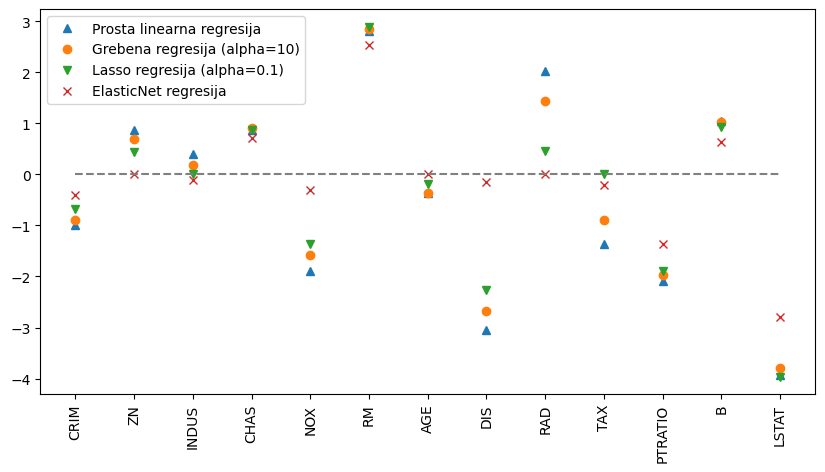

In [47]:
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(0, number_of_features), feature_names, rotation='vertical')
plt.plot(linear.coef_, '^', label='Prosta linearna regresija' )
plt.plot(ridge.coef_, 'o', label='Grebena regresija (alpha=10)')
plt.plot(lasso.coef_, 'v', label='Lasso regresija (alpha=0.1)')
plt.plot(elastic.coef_, 'x', label='ElasticNet regresija')
plt.plot(np.arange(0, number_of_features), np.zeros(number_of_features), color='gray', linestyle='--')
plt.legend(loc='best')
plt.show()

Optimalne vrednosti hiperparametara koji se javljaju u regularizovanim modelima se određuju na isti način na koji se određuju i hipermarametri do sada posmatranih modela.